In [130]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.stats import pearsonr
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

from scipy.optimize import curve_fit

# Load the full scan

In [137]:
fc = FileChooser('/sf/alvra/data/p18956/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18956/raw/scan_info', filename='', show_hidden='False')

In [145]:
quantile_corr = 0.3

channel_list_pp = [channel_Events, channel_APD_Ch1, channel_APD_Ch2, channel_Izero117]
channel_list_all = channel_list_pp + [channel_energy]

########################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
filter_deg = scan.readbacks

filter_deg = np.asarray(filter_deg)

DataAPD1_pump = []
DataAPD1_unpump = []
Pump_probe_APD1 = []

DataAPD2_pump = []
DataAPD2_unpump = []
Pump_probe_APD2 = []

for i, step in enumerate(scan):
    try:
        check_files_and_data(step)
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]

        resultsPP, results, _, _ = load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)

        IzeroFEL_pump_shot = resultsPP[channel_Izero117].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero117].unpump
        DataAPD1_pump_shot = resultsPP[channel_APD_Ch1].pump
        DataAPD1_unpump_shot = resultsPP[channel_APD_Ch1].unpump
        DataAPD2_pump_shot = resultsPP[channel_APD_Ch2].pump
        DataAPD2_unpump_shot = resultsPP[channel_APD_Ch2].unpump
        
        DataAPD1_pump_shot_norm = DataAPD1_pump_shot / IzeroFEL_pump_shot
        DataAPD1_unpump_shot_norm = DataAPD1_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_APD1_shot = DataAPD1_pump_shot_norm - DataAPD1_unpump_shot_norm
        
        DataAPD2_pump_shot_norm = DataAPD2_pump_shot / IzeroFEL_pump_shot
        DataAPD2_unpump_shot_norm = DataAPD2_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_APD2_shot = DataAPD2_pump_shot_norm - DataAPD2_unpump_shot_norm

        df_pump_APD1 = pd.DataFrame(DataAPD1_pump_shot_norm)
        df_unpump_APD1 = pd.DataFrame(DataAPD1_unpump_shot_norm)
        df_pump_probe_APD1 = pd.DataFrame(Pump_probe_APD1_shot)
        
        df_pump_APD2 = pd.DataFrame(DataAPD2_pump_shot_norm)
        df_unpump_APD2 = pd.DataFrame(DataAPD2_unpump_shot_norm)
        df_pump_probe_APD2 = pd.DataFrame(Pump_probe_APD2_shot)

        DataAPD1_pump.append(np.nanquantile(df_pump_APD1, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataAPD1_unpump.append(np.nanquantile(df_unpump_APD1, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe_APD1.append(np.nanquantile(df_pump_probe_APD1, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        DataAPD2_pump.append(np.nanquantile(df_pump_APD2, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataAPD2_unpump.append(np.nanquantile(df_unpump_APD2, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe_APD2.append(np.nanquantile(df_pump_probe_APD2, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
    except:
        filter_deg = np.delete(filter_deg, i)
    
    
    print ('Step {} of {}: Processed {}'.format(i+1, len(scan.files), filename))
    print ("correlation APD1 = {}".format(pearsonr(IzeroFEL_pump_shot,DataAPD1_pump_shot)[0]))
    print ("correlation APD2 = {}".format(pearsonr(IzeroFEL_pump_shot,DataAPD2_pump_shot)[0]))
    
DataAPD1_pump = np.asarray(DataAPD1_pump)
DataAPD1_unpump = np.asarray(DataAPD1_unpump)
Pump_probe_APD1 = np.asarray(Pump_probe_APD1)

DataAPD2_pump = np.asarray(DataAPD2_pump)
DataAPD2_unpump = np.asarray(DataAPD2_unpump)
Pump_probe_APD2 = np.asarray(Pump_probe_APD2)

#minlen = min(len(i) for i in Pump_probe_APD1)
#def cut(arr, minlen):
#    return np.array([i[:minlen] for i in arr])

# DataAPD1_pump = cut(DataAPD1_pump, minlen)
# DataAPD1_unpump = cut(DataAPD1_unpump, minlen)
# Pump_probe_APD1 = cut(Pump_probe_APD1, minlen)
# DataAPD2_pump = cut(DataAPD2_pump, minlen)
# DataAPD2_unpump2 = cut(DataAPD2_unpump, minlen)
# Pump_probe_APD2 = cut(Pump_probe_APD2, minlen)

print ("Job done!")



--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET          2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY         1966 / 2001 -> 2% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1966 / 2001 -> 2% loss
complete channels: 4 / 5 -> 20% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 965 pump and 965 unpump shots
Step 23 of 23: Processed run_007073
correlation APD1 = 0.9874393672283727
correlation APD2 = 0.9879446545625731
Job done!


# Plot Fluence scan

<IPython.core.display.Javascript object>


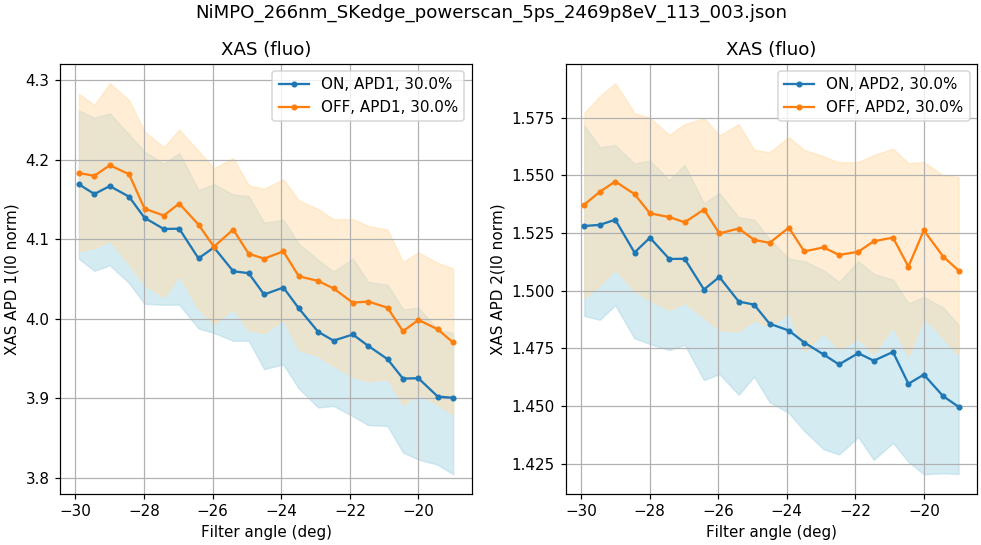

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_APD1_pump = DataAPD1_pump[:,0]
err_APD1_low_pump = DataAPD1_pump[:,1]
err_APD1_high_pump = DataAPD1_pump[:,2]
XAS_APD1_unpump = DataAPD1_unpump[:,0]
err_APD1_low_unpump = DataAPD1_unpump[:,1]
err_APD1_high_unpump = DataAPD1_unpump[:,2]
XAS_APD1_pump_probe = Pump_probe_APD1[:,0]
err_APD1_low_pump_probe = Pump_probe_APD1[:,1]
err_APD1_high_pump_probe = Pump_probe_APD1[:,2]

XAS_APD2_pump = DataAPD2_pump[:,0]
err_APD2_low_pump = DataAPD2_pump[:,1]
err_APD2_high_pump = DataAPD2_pump[:,2]
XAS_APD2_unpump = DataAPD2_unpump[:,0]
err_APD2_low_unpump = DataAPD2_unpump[:,1]
err_APD2_high_unpump = DataAPD2_unpump[:,2]
XAS_APD2_pump_probe = Pump_probe_APD2[:,0]
err_APD2_low_pump_probe = Pump_probe_APD2[:,1]
err_APD2_high_pump_probe = Pump_probe_APD2[:,2]

# plt.subplot(1,2,1)
ax1.plot(filter_deg, XAS_APD1_pump, label='ON, APD1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(filter_deg, err_APD1_low_pump, err_APD1_high_pump, color='lightblue', alpha=0.5)

ax1.plot(filter_deg, XAS_APD1_unpump, label='OFF, APD1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(filter_deg, err_APD1_low_unpump, err_APD1_high_unpump, color='navajowhite',alpha=0.5)

ax1.set_xlabel("Filter angle (deg)")
ax1.set_ylabel ("XAS APD 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

# plt.subplot(1,2,2)
ax2.plot(filter_deg, XAS_APD2_pump, label='ON, APD2, {}%'.format(quantile_corr*100),marker='.')
ax2.fill_between(filter_deg, err_APD2_low_pump, err_APD2_high_pump, color='lightblue',alpha=0.5)

ax2.plot(filter_deg, XAS_APD2_unpump, label='OFF, APD2, {}%'.format(quantile_corr*100),marker='.')
ax2.fill_between(filter_deg, err_APD2_low_unpump, err_APD2_high_unpump, color='navajowhite',alpha=0.5)

ax2.set_xlabel("Filter angle (deg)")
ax2.set_ylabel ("XAS APD 2(I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

#plt.subplot(1,3,3)
#plt.plot(filter_deg, XAS_APD_pump_probe, label='pump-probe, APD, {}%'.format(quantile_corr*100),color='green', marker='.')
#plt.fill_between(filter_deg,err_APD_low_pump_probe, err_APD_high_pump_probe, color='lightgreen')

#plt.plot(filter_deg, XAS_PIPS_pump_probe, label='pump-probe, PIPS, {}%'.format(quantile_corr*100),color='magenta', marker='.')
#plt.fill_between(filter_deg,err_PIPS_low_pump_probe, err_PIPS_high_pump_probe, color='pink')


#plt.xlabel("Energy (eV)")
#plt.ylabel ("DeltaXAS (I0 norm)")
#plt.gca().set_title('pump-probe vs energy')
#plt.legend(loc="best")
#plt.grid()
# plt.tight_layout()

plt.show()



<IPython.core.display.Javascript object>


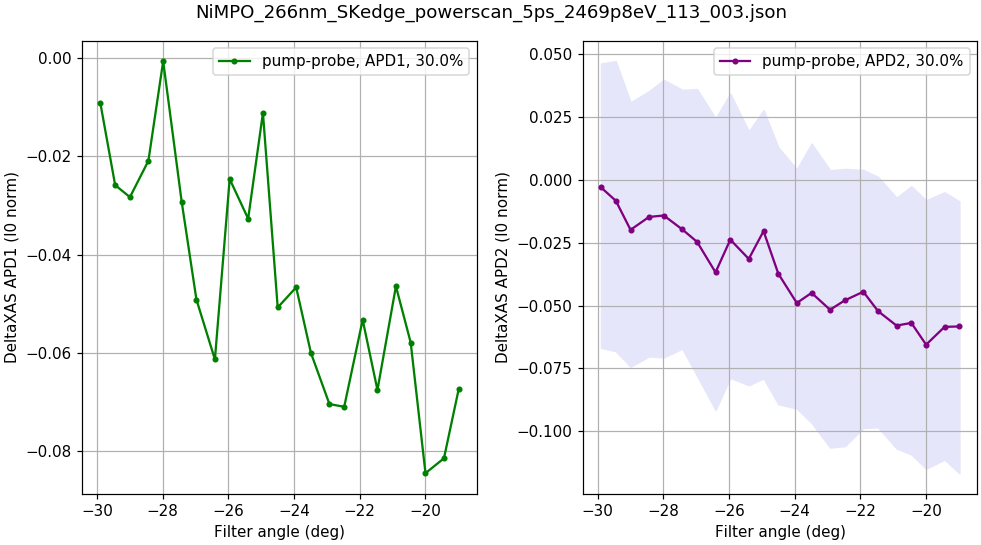

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

# plt.subplot(1,2,1)
ax1.plot(filter_deg, XAS_APD1_pump_probe, label='pump-probe, APD1, {}%'.format(quantile_corr*100),color='green', marker='.')
# ax1.fill_between(filter_deg,err_APD1_low_pump_probe, err_APD1_high_pump_probe, color='lightgreen')

ax1.set_xlabel("Filter angle (deg)")
ax1.set_ylabel ("DeltaXAS APD1 (I0 norm)")
ax1.set_title('')
ax1.legend(loc="best")
# ax1.set_ylim(-0.4,0.2)
ax1.grid()
# plt.tight_layout()

# plt.subplot(1,2,2)
ax2.plot(filter_deg, XAS_APD2_pump_probe, label='pump-probe, APD2, {}%'.format(quantile_corr*100),color='purple', marker='.')
ax2.fill_between(filter_deg,err_APD2_low_pump_probe, err_APD2_high_pump_probe, color='lavender')

ax2.set_xlabel("Filter angle (deg)")
ax2.set_ylabel ("DeltaXAS APD2 (I0 norm)")
ax2.set_title('')
ax2.legend(loc="best")
ax2.grid()
# plt.tight_layout()


plt.show()


<IPython.core.display.Javascript object>


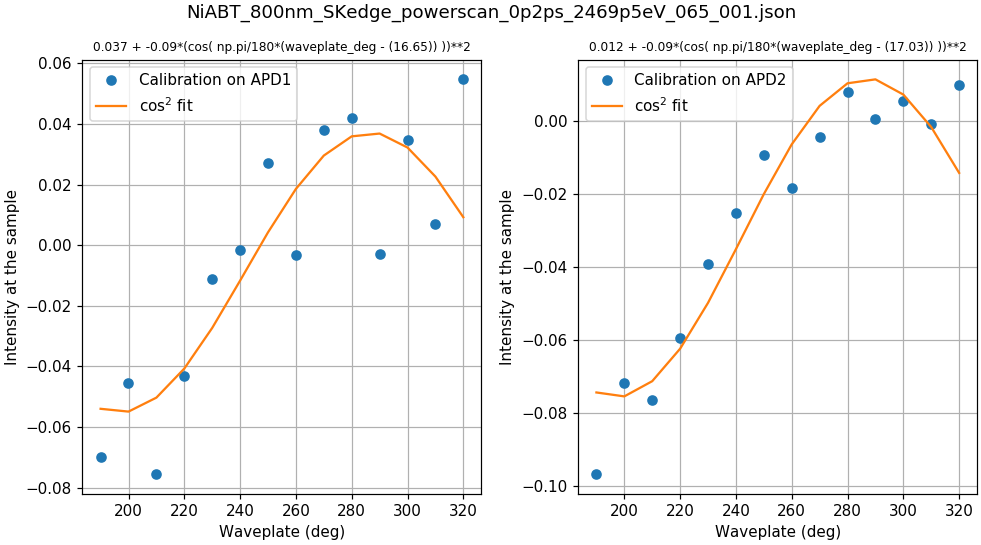

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

xdata = filter_deg
ydata = XAS_APD1_pump_probe

def cosine_fit(xdata, xshift, yshift, yscale):
    return yshift + yscale*(np.cos(np.pi/180.*(xdata - xshift)))**2

popt, pcov = curve_fit(cosine_fit, xdata, ydata)
ax1_title = ('{:.3f} + {:.2f}*(cos( np.pi/180*(waveplate_deg - ({:.2f})) ))**2'.format(popt[1],popt[2],popt[0]))

ax1.set_title(ax1_title, fontsize=8)
ax1.plot(xdata, ydata, 'o', label='Calibration on APD1', linestyle='none')
ax1.plot(xdata, cosine_fit(xdata, *popt), label=r'cos$^2$ fit')

ax1.set_xlabel('Waveplate (deg)')
ax1.set_ylabel('Intensity at the sample')

ax1.grid()
ax1.legend()


xdata = filter_deg
ydata = XAS_APD2_pump_probe

def cosine_fit(xdata, xshift, yshift, yscale):
    return yshift + yscale*(np.cos(np.pi/180.*(xdata - xshift)))**2

popt, pcov = curve_fit(cosine_fit, xdata, ydata)
ax2_title = ('{:.3f} + {:.2f}*(cos( np.pi/180*(waveplate_deg - ({:.2f})) ))**2'.format(popt[1],popt[2],popt[0]))

ax2.set_title(ax2_title, fontsize=8)
ax2.plot(xdata, ydata, 'o', label='Calibration on APD2', linestyle='none')
ax2.plot(xdata, cosine_fit(xdata, *popt), label=r'cos$^2$ fit')

ax2.set_xlabel('Waveplate (deg)')
ax2.set_ylabel('Intensity at the sample')

ax2.grid()
ax2.legend()

plt.show()

In [ ]:
##Gentec reading 

[100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 270 290]


<IPython.core.display.Javascript object>


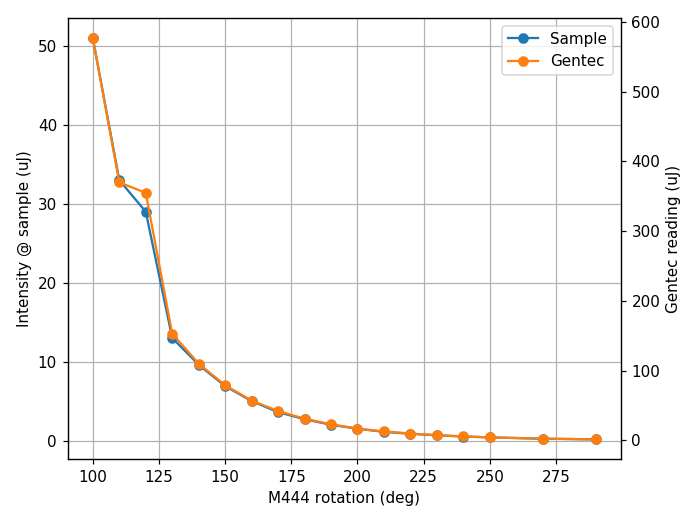

In [35]:
m444 = np.arange(100,300,10)
m444 = np.delete(m444, [-2, -4])
print(m444)
gen = np.array([577, 370, 355, 153, 110, 79, 57, 42, 31, 23, 16.7, 12.7, 9.7, 7.4, 5.6, 4.2, 2.42, 1.36])
sample = np.array([51,33,29, 13, 9.6, 6.9, 5.0, 3.6, 2.7, 2.0, 1.5, 1.1, 0.86, 0.66, 0.51, 0.40, 0.23, 0.15])

fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax2 = plt.twinx(ax1)

ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

lns1 = ax1.plot(m444, sample, 'o-', label='Sample')
lns2 = ax2.plot(m444, gen, 'o-',label='Gentec')

ax1.set_xlabel('M444 rotation (deg)')
ax2.set_ylabel('Gentec reading (uJ)')
ax1.set_ylabel('Intensity @ sample (uJ)')

# ax1.set_ylim(0,12)
# ax2.set_ylim(0,36)

leg = lns1 + lns2
labels = [l.get_label() for l in leg]
ax1.legend(leg, labels, loc='best')
ax1.grid()

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


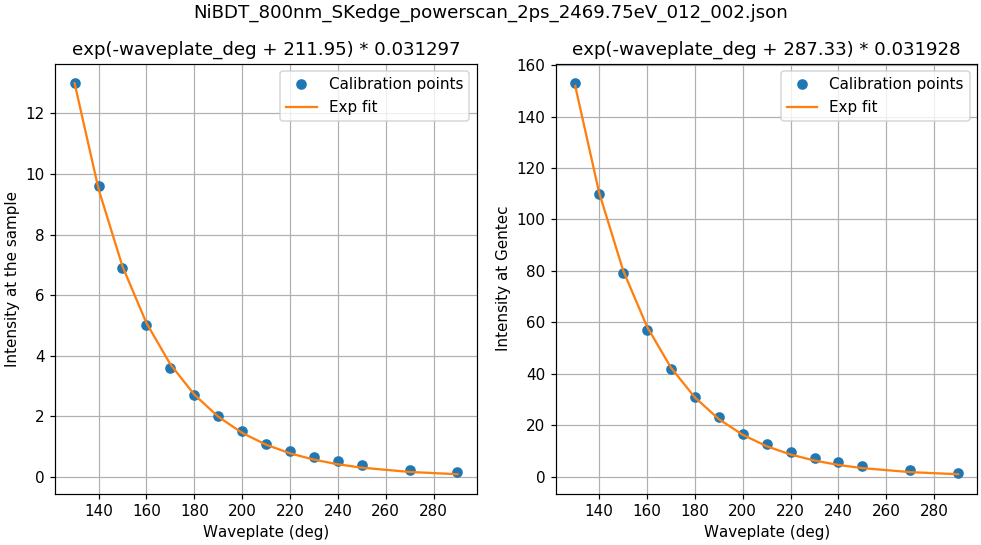

In [126]:
def exp_fit(xdata, xshift, a):
    return (np.exp(  (- xdata + xshift)*a  ))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

xdata = m444[3:]
ydata = gen[3:]

xgrid=np.linspace(110,300,1000)

popt2, pcov = curve_fit(exp_fit, xdata, ydata, p0 = [213, 0.04])

ax2.set_title('exp(-waveplate_deg + {:.2f}) * {:f}'.format(*popt2))
ax2.plot(xdata, ydata, 'o', label='Calibration points', linestyle='none')
ax2.plot(xdata, exp_fit(xdata, *popt2), label=r'Exp fit')

ax2.set_xlabel('Waveplate (deg)')
ax2.set_ylabel('Intensity at Gentec')

ax2.grid()
ax2.legend()


xdata = m444[3:]
ydata = sample[3:]

xgrid=np.linspace(110,300,1000)

popt1, pcov = curve_fit(exp_fit, xdata, ydata, p0 = [213, 0.04])

ax1.set_title('exp(-waveplate_deg + {:.2f}) * {:f}'.format(*popt1))
ax1.plot(xdata, ydata, 'o', label='Calibration points', linestyle='none')
ax1.plot(xdata, exp_fit(xdata, *popt1), label=r'Exp fit')

ax1.set_xlabel('Waveplate (deg)')
ax1.set_ylabel('Intensity at the sample')

ax1.grid()
ax1.legend()


plt.show()

<IPython.core.display.Javascript object>


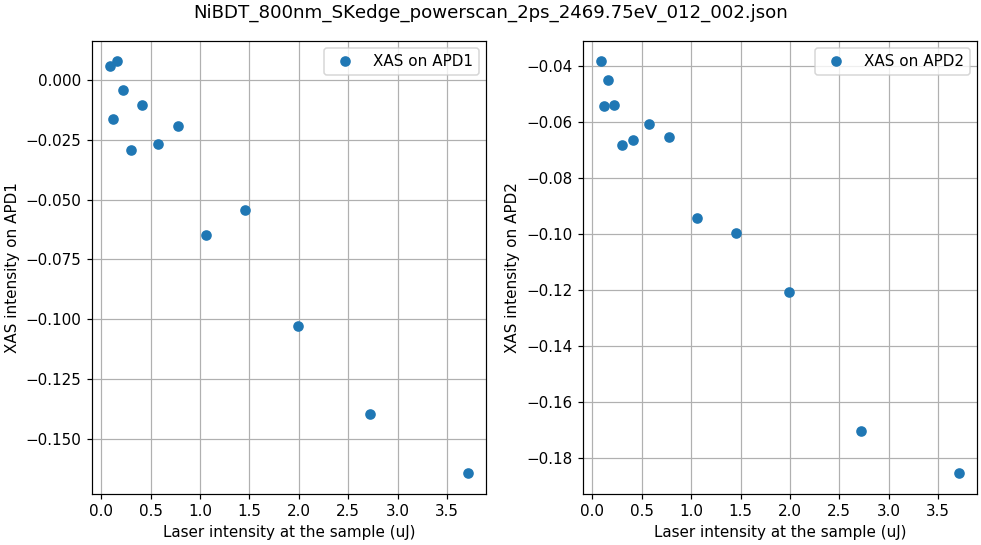

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

xdata = exp_fit(filter_deg, *popt1)
ydata = XAS_APD1_pump_probe

ax1.plot(xdata, ydata, 'o', label='XAS on APD1', linestyle='none')

ax1.set_xlabel('Laser intensity at the sample (uJ)')
ax1.set_ylabel('XAS intensity on APD1')

ax1.grid()
ax1.legend()


xdata = exp_fit(filter_deg, *popt1)
ydata = XAS_APD2_pump_probe

popt, pcov = curve_fit(cosine_fit, xdata, ydata)

ax2.plot(xdata, ydata, 'o', label='XAS on APD2', linestyle='none')

ax2.set_xlabel('Laser intensity at the sample (uJ)')
ax2.set_ylabel('XAS intensity on APD2')

ax2.grid()
ax2.legend()

plt.show()

# Calculate laser fluence 

In [17]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

[71.4375 70.0875 68.625  67.275  65.8125 64.4625 63.     61.65   60.3
 58.8375 57.4875]
[294.57418891 300.29098644 306.16636561 311.28353047 316.48180893
 320.95006004 325.42117553 329.19748117 332.62831071 335.9463667
 338.63389868]


<IPython.core.display.Javascript object>


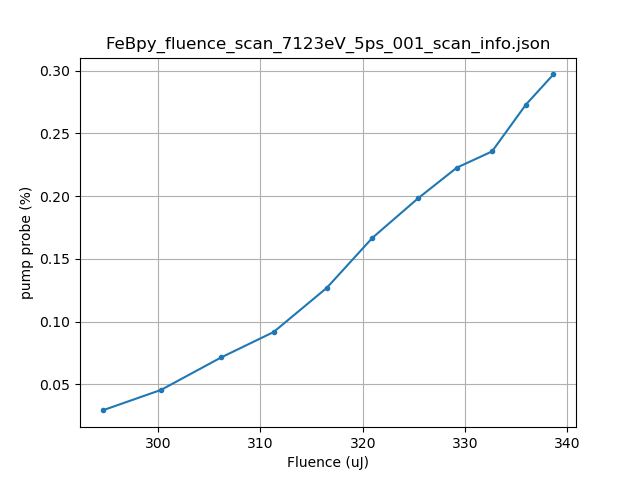

In [20]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(fc.selected.split('/')[-1])
plt.plot(fluences, XAS_pump_probe/XAS_unpump, marker = '.')
plt.grid()
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')
plt.show()

# Load one step and check I0 filtering

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:37 07.07.2019
    mtime difference: -0:11:19.007286
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF06T04V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF06T04V01.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:45 07.07.2019
    mtime difference: -0:19:33.451366
SFDataFiles("/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.BSREAD.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF02T09V02.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF06T04V01.h5"): 62 channels

----------

<IPython.core.display.Javascript object>


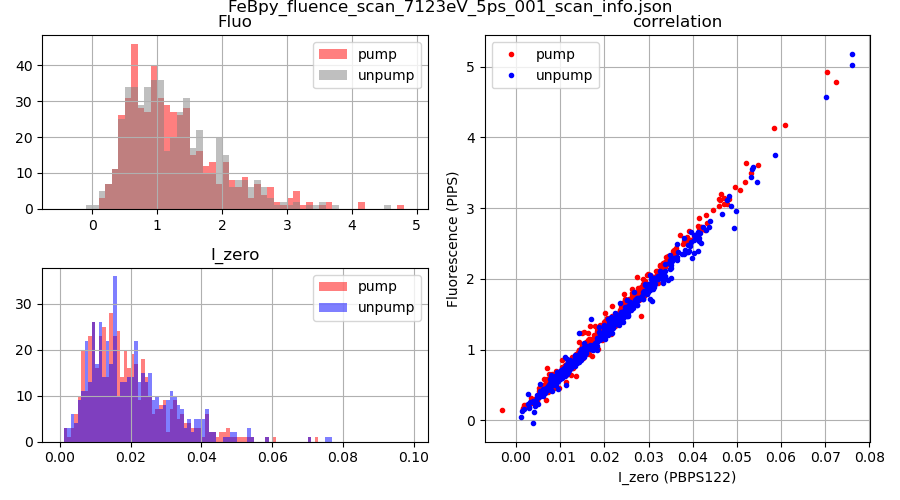

In [44]:
filenumber = 1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122L]
channel_list_all = channel_list_pp + [channel_waveplate]

########################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Waveplate_deg = scan.readbacks
step = scan[filenumber]
print (step)

resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

IzeroFEL_pump_shot = resultsPP[channel_Izero122L].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122L].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

#(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
# DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(fn, channel_energy)

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

print ("Waveplate = {} degrees".format(Waveplate_deg[filenumber]))
print ("Median value Izero (all) = {}".format(np.median(np.concatenate((IzeroFEL_pump_raw, IzeroFEL_unpump_raw), axis=0))))
print ("Median value fluo (all) = {}".format(np.median(np.concatenate((DataFluo_pump_shot_raw, DataFluo_unpump_shot_raw), axis=0))))
print ("Correlation = {}".format(pearsonr(IzeroFEL_pump_shot,DataFluo_pump_shot)[0]))

fig = plt.figure(figsize=(9,5))
plt.suptitle(fc.selected.split('/')[-1], y =1)
plt.subplots_adjust(top=0.9)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,5,0.1), facecolor='red', label="pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.5,5,0.1), facecolor='grey', label="unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.1,0.001), facecolor='red', label='pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.1,0.001), facecolor='blue', label ='unpump', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

#plt.tight_layout()

plt.show()

In [31]:
filenumber = 1

channel_list_pp = [channel_Events, channel_PIPS_fluo, channel_Izero122L]
channel_list_all = channel_list_pp + [channel_waveplate]

min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Waveplate_deg = scan.readbacks
step = scan[filenumber]
print (step)

resultsPP, results, _, _= load_data_compact_laser_pump(channel_list_pp, channel_list_all, step)
step.close()

IzeroFEL_pump_shot = resultsPP[channel_Izero122L].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122L].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Waveplate angle = {} deg".format(Waveplate_deg[filenumber]))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))


Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:37 07.07.2019
    mtime difference: -0:11:19.007286
Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF06T04V01/gains.h5
Auto-located pedestal file: /sf/alvra/data/p17589/res/JF_pedestals/pedestal_20190707_1017.JF06T04V01.res.h5
jungfrau file: 10:26 07.07.2019
pedestal file: 10:45 07.07.2019
    mtime difference: -0:19:33.451366
SFDataFiles("/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.BSREAD.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF02T09V02.h5", "/sf/alvra/data/p17589/raw/scan_data/FeBpy_fluence_scan_7123eV_5ps_001/FeBpy_fluence_scan_7123eV_5ps_001_step0001.JF06T04V01.h5"): 62 channels

----------

<IPython.core.display.Javascript object>


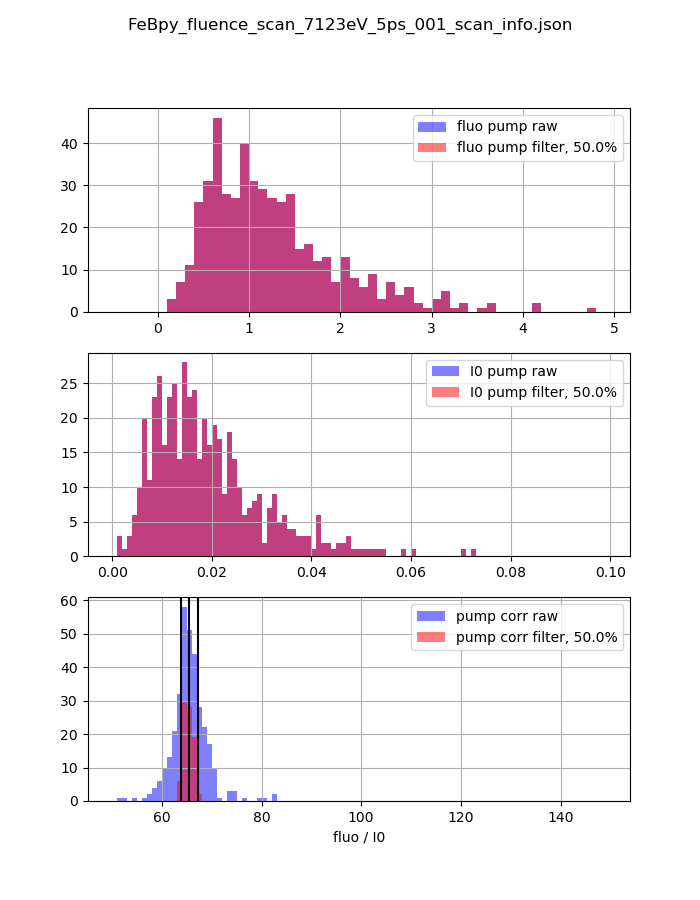

quantile range = 0.25 0.75


In [49]:
plt.figure(figsize = (7,9))
plt.suptitle(fc.selected.split('/')[-1])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,5,0.1), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,5,0.1), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.1,0.001), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.1,0.001), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(50,150,1)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

#plt.tight_layout()

plt.show()
print ('quantile range = {}'.format(0.5 - quantile_corr/2), 0.5 + quantile_corr/2)